In [3]:
!pip install vit-keras
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 11.4 MB/s eta 0:00:0000:0100:01


# Import Libraries and Define Functions

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from vit_keras import vit, utils
import tensorflow_datasets as tfds
import pickle 
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc

def load_images(file_paths, labels):
    images = [tf.io.read_file(file_path) for file_path in file_paths]
    images = [tf.image.decode_jpeg(img,channels=3) for img in images]
    return tf.data.Dataset.from_tensor_slices((images, labels))

def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    if image.shape[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image = image / 255.0
    return image, label

def create_vit_model(base_model,input_shape, num_classes):

    # Freeze all layers except for the last 30 layers
    for layer in base_model.layers[-30:]:
        layer.trainable = True
    model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.Flatten(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(128, activation = 'relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, 'sigmoid')
        ])

#     model = models.Model(inputs=base_model.inputs, outputs=output)

    return model
def create_dataset(folder_path, train_ratio=0.9):
    sub_dir = os.path.join(folder_path, "sub")
    no_sub_dir = os.path.join(folder_path, "no_sub")

    sub_files = [os.path.join(sub_dir, f) for f in os.listdir(sub_dir) if f.endswith(".jpg")]
    no_sub_files = [os.path.join(no_sub_dir, f) for f in os.listdir(no_sub_dir) if f.endswith(".jpg")]

    all_files = sub_files + no_sub_files
    np.random.shuffle(all_files)

    split_idx = int(len(all_files) * train_ratio)
    train_files = all_files[:split_idx]
    test_files = all_files[split_idx:]

    train_data = [{"file_path": file_path, "label": 0 if "no_sub" in file_path else 1} for file_path in train_files]
    test_data = [{"file_path": file_path, "label": 0 if "no_sub" in file_path else 1} for file_path in test_files]

    return train_data, test_data
def display_images(images, labels, num_columns, class_names):
    num_images = len(images)
    num_rows = np.ceil(num_images / num_columns).astype(int)

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(3 * num_columns, 3 * num_rows))

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(images[i], cmap='gray')
            ax.set_title(f"{class_names[labels[i]]}")
        ax.axis("off")

    plt.show()
def load_evaluate_summarize_model(model,weights_path, test_ds):
    # Load the model
    model.load_weights(weights_path)
    # Evaluate the model's performance
    test_labels = []
    test_probs = model.predict(test_ds)

    for _, y_true in test_ds:
        test_labels.extend(y_true.numpy())

    test_labels = np.array(test_labels)

    # Calculate RoC-Auc score
    roc_auc = roc_auc_score(test_labels, test_probs)

    print("Test Results:")
    print(f"RoC-Auc: {roc_auc}")

    # Plot ROC curve
    plt.figure()
    fpr, tpr, _ = roc_curve(test_labels, test_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


2023-04-02 20:00:22.321081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 20:00:22.646954: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/gwan/micromamba/envs/cs109b/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Parameters

In [2]:
batch_size = 16
input_shape = (224, 224, 3)
num_classes = 1
epochs = 50

es_callback = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True)
callbacks = [es_callback]

# Data Proprocessing

In [3]:
# Create the dataset
folder_path = "lenses/lenses"
train_files, test_files = create_dataset(folder_path)


train_ds = load_images([item["file_path"] for item in train_files], [item["label"] for item in train_files])
test_ds = load_images([item["file_path"] for item in test_files], [item["label"] for item in test_files])


2023-04-02 20:00:35.582720: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-02 20:00:36.224926: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-02 20:00:36.225590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-02 20:00:36.246832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FM

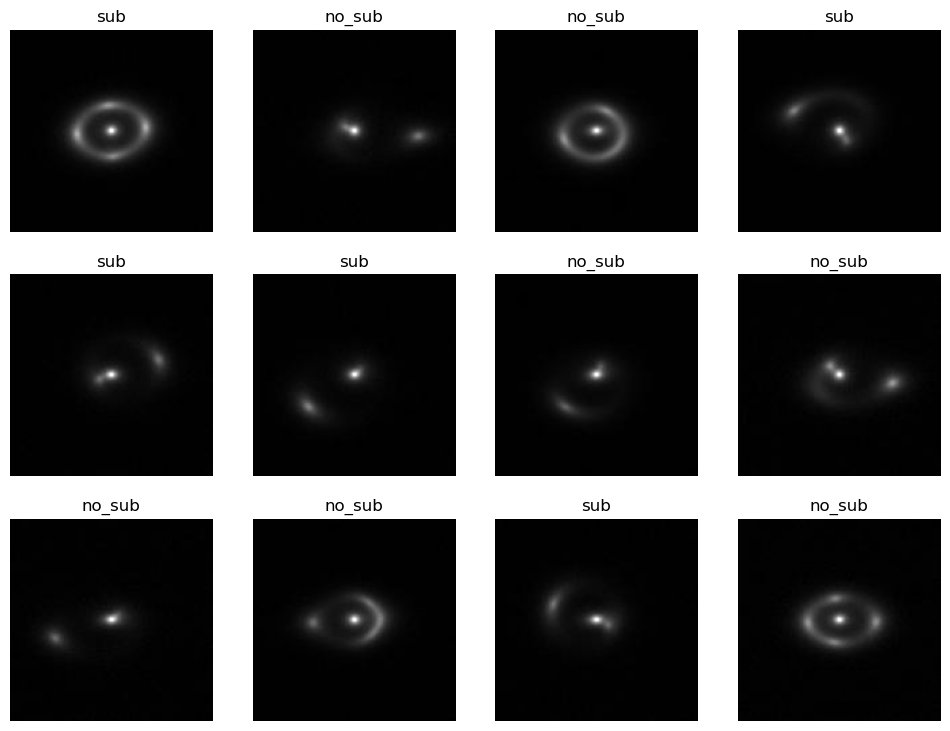

In [4]:
# Load some images and labels from the dataset
num_samples = 12


# Convert the dataset to NumPy arrays
train_images = [x.numpy() for x, y in train_ds.take(num_samples)]
train_labels = [y.numpy() for x, y in train_ds.take(num_samples)]


# Define class names for labels
class_names = {0: "no_sub", 1: "sub"}

# Display the images and their labels in a grid with 4 columns
display_images(train_images, train_labels, num_columns=4, class_names=class_names)

In [5]:
# Preprocess and batch the dataset

train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Model Fitting/Saving

# VIT B16 (https://arxiv.org/pdf/2010.11929.pdf)

In [7]:
do_train = False

In [6]:
# Create model
if do_train:
    base_model = vit.vit_b16(
            image_size=input_shape[0],
            activation='sigmoid',
            pretrained=True,
            include_top=False,
            pretrained_top=False,
            weights='imagenet21k'
        )
    model_b16 = create_vit_model(base_model,input_shape, num_classes)
    model_b16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 1e-4),
                loss='binary_crossentropy',
                
                metrics=[tf.keras.metrics.AUC(curve='ROC')])

    # Train the model

    history_b16 = model_b16.fit(train_ds, validation_data=test_ds, shuffle=True, callbacks = callbacks,epochs=epochs)

412815506/412815506 [==============================] - 6s 0us/step
Epoch 1/50
563/563 [==============================] - 286s 422ms/step - loss: 0.6721 - auc: 0.6954 - val_loss: 3.2742 - val_auc: 0.6197
Epoch 2/50
563/563 [==============================] - 234s 416ms/step - loss: 0.2458 - auc: 0.9632 - val_loss: 1.8425 - val_auc: 0.8612
Epoch 3/50
563/563 [==============================] - 234s 415ms/step - loss: 0.1601 - auc: 0.9844 - val_loss: 0.1248 - val_auc: 0.9926
Epoch 4/50
563/563 [==============================] - 234s 415ms/step - loss: 0.1210 - auc: 0.9908 - val_loss: 0.1555 - val_auc: 0.9817
Epoch 5/50
563/563 [==============================] - 233s 415ms/step - loss: 0.1104 - auc: 0.9923 - val_loss: 0.4122 - val_auc: 0.9766
Epoch 6/50
563/563 [==============================] - 232s 412ms/step - loss: 0.0970 - auc: 0.9940 - val_loss: 0.9400 - val_auc: 0.9648
Epoch 7/50
563/563 [==============================] - 234s 415ms/step - loss: 0.0917 - auc: 0.9945 - val_loss: 0.4311

In [7]:
model_b16.save_weights('model_weights/vitb16_weights.h5')

# Save the history
with open('history_vitb16.pkl', 'wb') as file:
    pickle.dump(history_b16.history, file)

# Model Loading/Summaries

2023-04-02 19:59:07.110302: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-04-02 19:59:14.579000: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-02 19:59:14.828787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


63/63 [==============================] - 24s 114ms/step
Test Results:
RoC-Auc: 0.9999319670720629


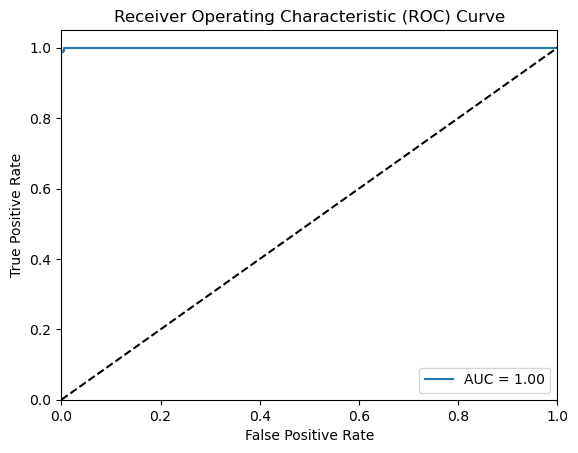

In [9]:
base_model = vit.vit_b16(
            image_size=input_shape[0],
            activation='sigmoid',
            pretrained=True,
            include_top=False,
            pretrained_top=False,
            weights='imagenet21k'
        )
model_b16 = create_vit_model(base_model,input_shape, num_classes)
load_evaluate_summarize_model(model_b16,'model_weights/vitb16_weights.h5',test_ds)

# Visuluzation Model History

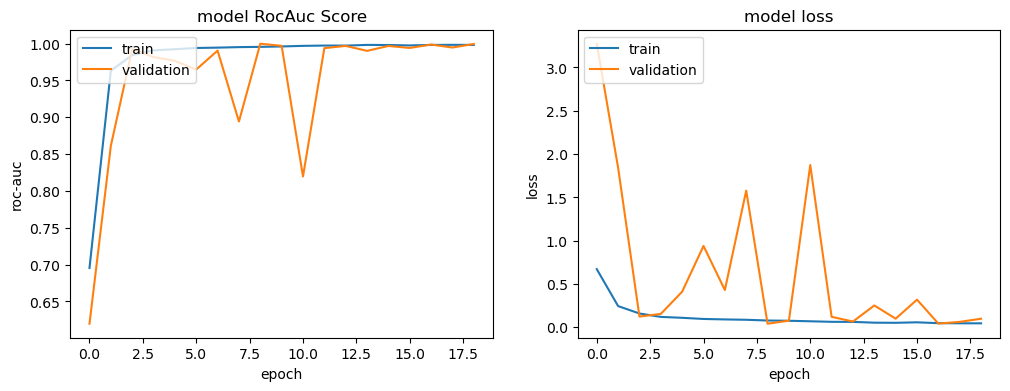

<Figure size 640x480 with 0 Axes>

In [30]:
def plot_loss(model_history):
    """
    This helper function plots the NN model accuracy and loss.
    Arguments:
        model_history: the model history return from fit()
        out_file: the (optional) path to save the image file to.
    """
    fig, ax = plt.subplots(1, 2, figsize = (12, 4))
    
    history = model_history
    
    ax[0].plot(history['auc'])
    ax[0].plot(history['val_auc'])
    ax[0].set_title('model RocAuc Score')
    ax[0].set_ylabel('roc-auc')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'test'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history['loss'])
    ax[1].plot(history['val_loss'])
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'test'], loc='upper left')
    plt.show()

best_history = pd.read_pickle(r'histories/vitb16.pkl')
plot_loss(model_history = best_history);